In [ ]:
# Open Anaconda Prompt and create a new environment
#conda create --name nlp_env python=3.9
#conda activate nlp_env

# Install necessary packages
#conda install -c conda-forge spacy
#pip install pydantic
#conda install pandas

# Download Spacy model
#python -m spacy download en_core_web_sm

# Import Libraries

In [2]:
import pandas as pd
import re
import spacy
from collections import Counter
import gensim
import gensim.corpora as corpora
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import matplotlib.pyplot as plt

# Definitions

In [62]:
# Load Spacy model
nlp = spacy.load("en_core_web_sm")

# Add "not" to the stop words list
nlp.Defaults.stop_words.add("not")
nlp.vocab["not"].is_stop = True
additional_stopwords = ['0', '0x0', 'not']

# Coordination terms
coord_terms = ["reuse", "copy", "clone", "common", "common developers", "license", "open source", "governance", "copyright", "open source software", "open-source", "cloning", "forking", "coordination", "collaboration",
               "bitcoin", "btc", "bch", "bitcoin cash"]

# Read CSV file
def read_csv(file_path):
    df = pd.read_csv(file_path)
    return df
    
# Preprocess text function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^\w\s]", "", text)  # Remove special characters
    text = re.sub(r"[\r\n]", "", text)    # Remove \r\n characters
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

# Function to preprocess the comments in the DataFrame
def preprocess_dataframe(df):
    
    # Preprocess the comments
    df['preprocessed_comments'] = df['body'].dropna().apply(preprocess_text)
    return df

# Extract coordination terms function with lemmatization
def extract_coordination_terms(text, coord_terms):
    term_count = Counter()
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    for lemma in lemmas:
        if lemma in coord_terms:
            term_count[lemma] += 1
    return term_count

# Function to get top comments based on keyword matches
def get_top_comments(preprocessed_df, coord_terms, top_n=5):
    # Initialize a list to store the comment and its keyword match count
    comments_with_matches = []
    
    for index, comment in preprocessed_df['preprocessed_comments'].items():
        terms = extract_coordination_terms(comment, coord_terms)
        total_matches = sum(terms.values())
        
        # Append the comment, index and total matches to the list
        comments_with_matches.append((index, preprocessed_df['preprocessed_comments'][index], total_matches))
    
    # Sort the list by total matches in descending order and get the top N comments
    top_comments = sorted(comments_with_matches, key=lambda x: x[2], reverse=True)[:top_n]
    
    return top_comments

# Tokenize and lemmatize the comments
def tokenize_and_lemmatize(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.lemma_ not in additional_stopwords and token.is_alpha]
    return tokens

# Function to prepare data for LDA
def prepare_lda_data(texts):
    data_words = [tokenize_and_lemmatize(text) for text in texts]
    id2word = corpora.Dictionary(data_words)
    corpus = [id2word.doc2bow(text) for text in data_words]
    return id2word, corpus, data_words

# Function to perform LDA and visualize the topics
def perform_lda(id2word, corpus, num_topics=5):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=num_topics, 
                                                random_state=100,
                                                update_every=1,
                                                chunksize=10,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
    return lda_model

# Visualize the topics
def visualize_topics(lda_model, corpus, id2word, html_filename):
    vis = gensimvis.prepare(lda_model, corpus, id2word)
    pyLDAvis.display(vis)
    pyLDAvis.save_html(vis, html_filename)

# Bitcoin Cash (BCH) Analysis

In [4]:
# File read
file_path = 'interesting_comments_bitcoin-abc.csv'
df = read_csv(file_path)

In [5]:
print(df.shape)
df[['body', 'keywords']].head()

(39, 5)


,body,keywords
0,GA is used for minimal usage data collection a...,open source
1,same error here..\r\r\nstarted with a fresh gi...,reuse
2,GA is used for minimal usage data collection a...,open source
3,same error here..\r\r\nstarted with a fresh gi...,reuse
4,@jasonbcox \r\r\n\r\r\n```\r\r\nlsb_release -a...,"copy,license"


In [46]:
preprocessed_df = preprocess_dataframe(df)
preprocessed_df.head()

,Unnamed: 0,created_at,body,developer,keywords,preprocessed_comments
0,46,2022-08-31T19:19:39Z,GA is used for minimal usage data collection a...,BytesOfMan,open source,ga is used for minimal usage data collection a...
1,235,2020-10-23T13:55:36Z,same error here..\r\r\nstarted with a fresh gi...,M8BWNN,reuse,same error herestarted with a fresh git clone ...
2,295,2022-08-31T19:19:39Z,GA is used for minimal usage data collection a...,BytesOfMan,open source,ga is used for minimal usage data collection a...
3,484,2020-10-23T13:55:36Z,same error here..\r\r\nstarted with a fresh gi...,M8BWNN,reuse,same error herestarted with a fresh git clone ...
4,614,2019-12-19T10:10:07Z,@jasonbcox \r\r\n\r\r\n```\r\r\nlsb_release -a...,gituser,"copy,license",jasonbcox lsb_release ano lsb modules are avai...


## Keyword Matching

In [47]:
# Lemmatized keyword matching
coordination_terms_count = Counter()
for comment in preprocessed_df['preprocessed_comments']:
    #processed_text = preprocess_text(comment)
    terms = extract_coordination_terms(comment, coord_terms)
    coordination_terms_count.update(terms)

print(coordination_terms_count)

Counter({'bitcoin': 30, 'license': 16, 'copyright': 16, 'copy': 7, 'bch': 4, 'btc': 3, 'clone': 2, 'governance': 1, 'coordination': 1})


In [48]:
top_comments = get_top_comments(preprocessed_df, coord_terms, top_n=5)

for index, comment, matches in top_comments:
    print(f"Comment Index: {index}\nComment: {comment}\nKeyword Matches: {matches}\n")

Comment Index: 18
Comment: whether it applies to a nonentity or not is a more esoteric question and im not a lawyer however regardless of the legal implications of a copyright stamp the license says basically you can use my stuff as long as you keep that little thing up there it does not say as long as that little thing up there is legally sound so the legality of the stamp and the requirements to keep it are completely separate concernssatoshi appears to have called him a bitcoin developer thats what he wrote personally and no one is allowed to change it the core team called themselves the bitcoin core developers and they claimed copyright from 2009 onwards and no one is allowed to change it if the 2009 is challenged in court and loses doesnt matter thats what they wrote and a condition of the license they gave us is that we dont change itnow your question does apply to the bitcoin abc developers since we are editing this and we have copyright ownership of our contributions however ev

## Keyword Matching Over Time

In [77]:
# Convert created_at to datetime format
preprocessed_df['created_at'] = pd.to_datetime(preprocessed_df['created_at'])

# Apply the function to the preprocessed_comments column
preprocessed_df['coord_term_counts'] = preprocessed_df['preprocessed_comments'].apply(lambda x: extract_coordination_terms(x, coord_terms))

# Aggregate the counts of coordination terms over time
# First, create a column for just the date (without time)
preprocessed_df['date'] = preprocessed_df['created_at'].dt.to_period('M')

# Initialize an empty Counter for aggregation
agg_counts = Counter()

# Sum up the counts per month
for date, group in preprocessed_df.groupby('date'):
    monthly_count = Counter()
    for counts in group['coord_term_counts']:
        monthly_count.update(counts)
    agg_counts[date] = monthly_count

# Convert aggregated counts to a DataFrame
agg_df = pd.DataFrame.from_dict(agg_counts, orient='index').fillna(0)

# Sort the DataFrame by the date index
agg_df = agg_df.sort_index()


C:\Users\spathiran\AppData\Local\Temp\ipykernel_15580\2260014974.py:9: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  preprocessed_df['date'] = preprocessed_df['created_at'].dt.to_period('M')


In [79]:
agg_df

,copy,copyright,bitcoin,bch,governance,coordination,license,btc,clone
2017-05,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-07,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08,0.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0
2017-09,2.0,13.0,10.0,3.0,0.0,0.0,13.0,3.0,0.0
2017-11,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-05,2.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-06,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02,0.0,1.0,5.0,0.0,0.0,0.0,3.0,0.0,0.0
2019-12,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


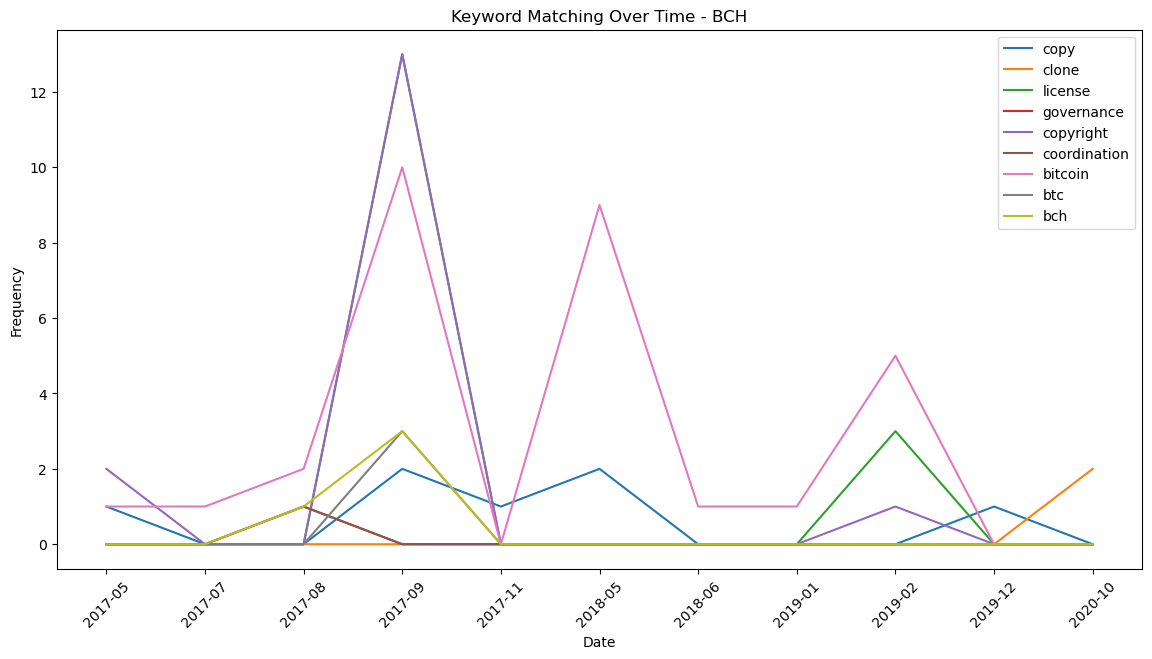

In [83]:
# Plot the results
plt.figure(figsize=(14, 7))
for term in coord_terms:
    if term in agg_df.columns:
        plt.plot(agg_df.index.astype(str), agg_df[term], label=term)
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Keyword Matching Over Time - BCH')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## Topic Modelling - BCH

In [63]:
# Prepare LDA data
id2word, corpus, data_words = prepare_lda_data(preprocessed_df['preprocessed_comments'])

# Perform LDA
lda_model = perform_lda(id2word, corpus, num_topics=2)

# Print the topics
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

# Visualize the topics
visualize_topics(lda_model, corpus, id2word, 'BCH_lda_topics.html')

(0, '0.133*"test" + 0.132*"perform" + 0.065*"look" + 0.054*"success" + 0.049*"find" + 0.015*"include" + 0.014*"file" + 0.013*"fail" + 0.010*"compiler" + 0.009*"c"')
(1, '0.013*"bitcoin" + 0.010*"code" + 0.008*"copyright" + 0.007*"fix" + 0.007*"license" + 0.007*"change" + 0.007*"core" + 0.007*"user" + 0.006*"release" + 0.006*"need"')


# Bitcoin (BTC) Analysis

In [9]:
# File read
file_path_btc = 'interesting_comments_bitcoin.csv'
btc_df = read_csv(file_path_btc)
print(btc_df.shape)
btc_df[['body', 'keywords']].head()

(3312, 5)


,body,keywords
0,> but we're changing all the types now so migh...,stuff
1,It would be good for the PR description to out...,copy
2,"Thanks, @1440000bytes for your review. Interes...",stuff
3,This error affected my btcpay server apparentl...,copy
4,> I don't see how reimplementing BDB is better...,stuff


In [56]:
preprocessed_btc_df = preprocess_dataframe(btc_df)
preprocessed_btc_df.head()

,Unnamed: 0,created_at,body,developer,keywords,preprocessed_comments
0,60,2022-12-07T15:33:53Z,> but we're changing all the types now so migh...,LarryRuane,stuff,but were changing all the types now so might a...
1,104,2022-12-20T10:55:38Z,It would be good for the PR description to out...,fanquake,copy,it would be good for the pr description to out...
2,122,2022-12-01T13:55:30Z,"Thanks, @1440000bytes for your review. Interes...",brunoerg,stuff,thanks 1440000bytes for your review interestin...
3,152,2022-12-11T00:41:12Z,This error affected my btcpay server apparentl...,cpleonardo,copy,this error affected my btcpay server apparentl...
4,183,2022-11-29T21:27:56Z,> I don't see how reimplementing BDB is better...,achow101,stuff,i dont see how reimplementing bdb is better th...


## Keyword Matching

In [57]:
# Lemmatized keyword matching
coordination_terms_count_btc = Counter()
for comment in preprocessed_btc_df['preprocessed_comments']:
    #processed_text = preprocess_text(comment)
    terms = extract_coordination_terms(comment, coord_terms)
    coordination_terms_count_btc.update(terms)

print(coordination_terms_count_btc)

Counter({'copy': 955, 'bitcoin': 872, 'reuse': 321, 'copyright': 290, 'license': 227, 'clone': 161, 'btc': 78, 'common': 54, 'coordination': 30, 'collaboration': 18, 'cloning': 6, 'forking': 5, 'governance': 1})


In [58]:
top_comments_btc = get_top_comments(preprocessed_btc_df, coord_terms, top_n=5)

#for index, comment, matches in top_comments_btc:
#    print(f"Comment Index: {index}\nComment: {comment}\nKeyword Matches: {matches}\n")

## Keyword Matching Over Time

In [85]:
# Convert created_at to datetime format
preprocessed_btc_df['created_at'] = pd.to_datetime(preprocessed_btc_df['created_at'])

# Apply the function to the preprocessed_comments column
preprocessed_btc_df['coord_term_counts'] = preprocessed_btc_df['preprocessed_comments'].apply(lambda x: extract_coordination_terms(x, coord_terms))

# Aggregate the counts of coordination terms over time
# First, create a column for just the date (without time)
preprocessed_btc_df['date'] = preprocessed_btc_df['created_at'].dt.to_period('M')

# Initialize an empty Counter for aggregation
agg_counts_btc = Counter()

# Sum up the counts per month
for date, group in preprocessed_btc_df.groupby('date'):
    monthly_count = Counter()
    for counts in group['coord_term_counts']:
        monthly_count.update(counts)
    agg_counts_btc[date] = monthly_count

# Convert aggregated counts to a DataFrame
agg_df_btc = pd.DataFrame.from_dict(agg_counts_btc, orient='index').fillna(0)

# Sort the DataFrame by the date index
agg_df_btc = agg_df_btc.sort_index()


C:\Users\spathiran\AppData\Local\Temp\ipykernel_15580\4064057201.py:9: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  preprocessed_btc_df['date'] = preprocessed_btc_df['created_at'].dt.to_period('M')


In [86]:
agg_df_btc

,copy,copyright,bitcoin,forking,license,btc,reuse,clone,common,coordination,collaboration,cloning,governance
2011-08,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-09,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-10,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-11,8.0,3.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-12,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08,10.0,0.0,16.0,0.0,0.0,0.0,5.0,0.0,2.0,0.0,3.0,0.0,0.0
2022-09,13.0,3.0,7.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-10,9.0,1.0,18.0,0.0,0.0,0.0,5.0,1.0,0.0,1.0,2.0,0.0,0.0
2022-11,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


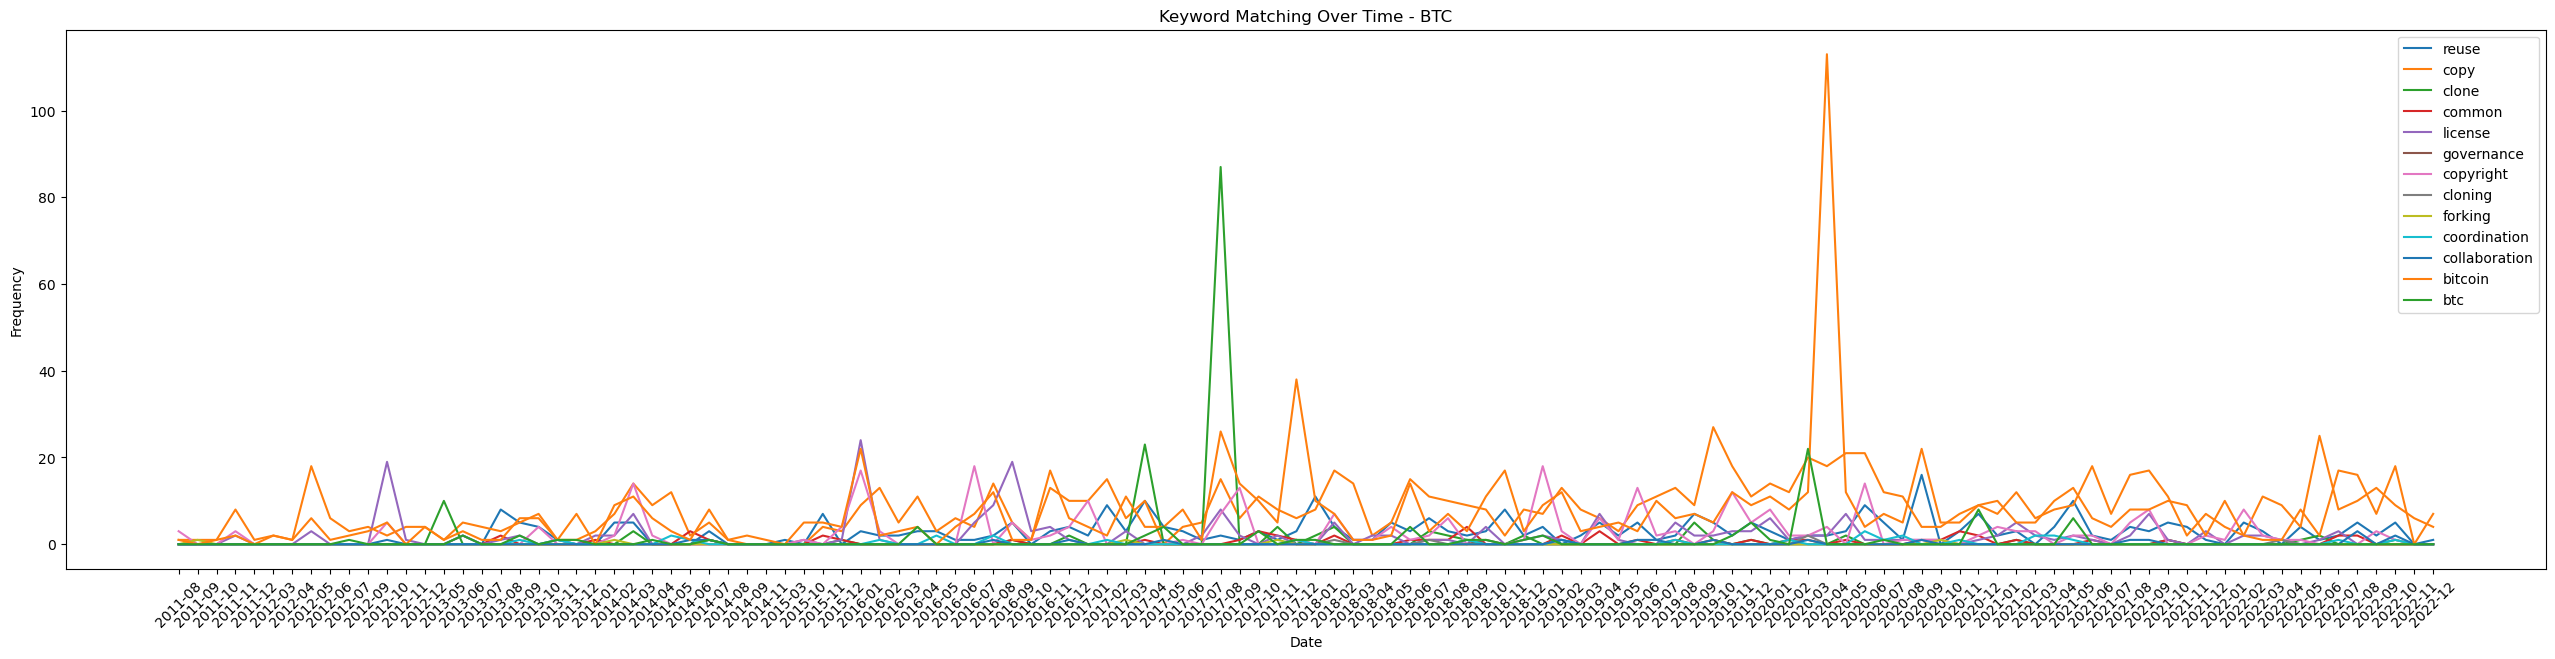

In [90]:
# Plot the results
plt.figure(figsize=(32, 7))
for term in coord_terms:
    if term in agg_df_btc.columns:
        plt.plot(agg_df_btc.index.astype(str), agg_df_btc[term], label=term)
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Keyword Matching Over Time - BTC')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## Topic Modelling - BTC

In [64]:
# Prepare LDA data
id2word_btc, corpus_btc, data_words_btc = prepare_lda_data(preprocessed_btc_df['preprocessed_comments'])

# Perform LDA
lda_model_btc = perform_lda(id2word_btc, corpus_btc, num_topics=2)

# Print the topics
topics_btc = lda_model_btc.print_topics(num_words=10)
for topic in topics_btc:
    print(topic)

# Visualize the topics
visualize_topics(lda_model_btc, corpus_btc, id2word_btc, 'BTC_lda_topics.html')

(0, '0.018*"libsystembdylib" + 0.012*"static" + 0.008*"const" + 0.008*"superdata" + 0.008*"stringdata" + 0.008*"extradata" + 0.008*"thread" + 0.007*"void" + 0.007*"int" + 0.006*"function"')
(1, '0.017*"stuff" + 0.009*"copy" + 0.008*"need" + 0.007*"like" + 0.007*"change" + 0.007*"file" + 0.006*"code" + 0.006*"m" + 0.006*"add" + 0.006*"think"')
